# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
from lightning.pytorch import seed_everything

seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

Seed set to 8


--------
### 実験設定

In [2]:
THRESHOLD = 2  # 外れ値除外の閾値

SAMPLE_SIZE = 100  # 標本サイズ
DATA_SIZE = 100000  # データサイズ(df2)
N_TRIALS = 100  # 試行回数（標本平均を求める回数）
N_EXPERIMENT = 10  # 分散を求める回数
m_VALUE = 2  # 各クラスタの最小標本数(最適標本配分)
RANDOM_STATE = 0  # 乱数シード
ALLOCATION_METHODS = [
    "Proportional",
    "Post",
    "Optimal",
]  # "Random"はいれない
CLUSTERING_METHOD = "gmm"  # "gmm" or "kmeans" or "xmeans"
CLUSTERING_METHOD_NAME = "GMM"

# クラスタを固定する場合(gmm, kmeans)
N_CLUSTERS = 2  # クラスタ数

# クラスタ数を固定しない場合（xmeans)
K_MIN = 2
K_MAX = 8


MAXIMUM_FEATURES_TO_SELECT = 10  # 選択される最大の特徴量数

SELECTING_FEATURES = "not_all_features"  # "all_features" or "not_all_features" #特徴量をすべて選ぶかどうか

-----------
### データの前処理（Data Preprocessing）

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### メルカリデータ（df1：全部, df2：一部）

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
obj1 = "GMV"
features_list1 = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]
obj2 = obj1
features_list2 = features_list1

##### 外れ値除去と標準化

In [5]:
df = df2  # choose from (df1, df2)
obj = obj2  # choose from (obj1, obj2)
features_list = features_list2  # choose from (features_list1, features_list2)

# 外れ値除去
df = remove_outliers_zscore(data=df, metric=obj, threshold=THRESHOLD)

# 標準化
X = df[features_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns=features_list)

# 目的変数
y = df[obj]

# 行を詰める
df = df.reset_index(drop=True)

print("外れ値除外前のデータ数:", DATA_SIZE)
print("外れ値除外後のデータ数:", len(df))

外れ値除外前のデータ数: 100000
外れ値除外後のデータ数: 99082


-------------
### 提案手法でクラスタリング

##### Allocation_in_Wrapper Class
とりあえずproportional でやってみる  
・データによってはクラスタ数=3と指定した場合も2になることもある  
⇒ この場合はscore = 0  
・クラスタ数が多すぎると母集団のある層のデータ数が１になることがある⇒最適標本配分ができない  
・最適標本配分の場合、xmeansよりもクラスタ数を２に固定したほうがいい  
⇒すべての層において最低標本サイズが最低２でなければいけないので、小さいクラスタの影響度が大きくなってしまい、誤った推定をしてしまう  
(もしクラスタサイズが1の層がある場合、その層からは抽出されない)

In [6]:
class Allocation_in_Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        maximum_features_to_select: int,
        n_clusters: int,
        clustering_method: str = "kmeans",
        allocation_methods: list[str] = ["Proportional"],
        sample_size: int = 10,
        n_trials: int = 100,
        m_value=2,
        M: Optional[NDArray] = None,
        random_state: int = 0,
        selecting_features: str = "all_features",
        k_min: int = 2,
        k_max: int = 10,
    ):
        self.maximum_features_to_select = maximum_features_to_select
        self.n_clusters = n_clusters
        self.clustering_method = clustering_method
        self.allocation_methods = allocation_methods
        self.sample_size = sample_size
        self.n_trials = n_trials
        self.m_value = m_value
        self.M = M
        self.random_state = random_state
        self.selecting_features = selecting_features
        self.k_min = k_min
        self.k_max = k_max

    def fss(
        self, X: pd.DataFrame, y: pd.DataFrame
    ) -> "Allocation_in_Wrapper":  ###これ自体は多分あってる
        X, y = check_X_y(X, y)
        n_all_features = X.shape[1]  # 総特徴量数
        self.final_selected_features_dict = {}  # キー：標本配分手法, 値：最終的に選ばれた特徴量のリスト
        self.final_cluster_assignments_dict = {}  # キー：標本配分手法, 値：最終的なクラスタラベル
        self.features_score_dict_dict = {}  # キー：標本配分手法, 値：features_score_dict
        self.features_error_variance_dict_dict = {}  # キー：標本配分手法, 値：features_error_variance_dict
        self.final_n_clusters_dict = {}  # キー：標本配分手法, 値：最終的なクラスタ数
        self.final_score_dict = {}
        self.final_error_variance_dict = {}

        # ランダムの分散を計算
        self.random_allocation_std = self.cauculate_random_std(X, y)

        # 特徴量選択
        for allocation_method in self.allocation_methods:
            print("[", allocation_method, "]")

            features_score_dict = {}
            features_error_variance_dict = {}

            # 選ばれた特徴量と残っている特徴量の初期化
            current_features = []
            remaining_features = list(range(n_all_features))
            best_labels = [-1 for i in range(len(X))]
            best_n_clusters = -1
            if self.selecting_features == "not_all_features":
                best_score = -np.inf

            while len(current_features) < self.maximum_features_to_select:
                if self.selecting_features == "all_features":
                    best_score = -np.inf
                best_feature = None  # 選ぶ特徴量の初期化

                for feature in remaining_features:
                    temp_features = tuple(
                        current_features + [feature]
                    )  # 特徴量をひとつ加え、score計算
                    score, error_variance, n_clusters = self.crit(
                        X[:, temp_features], y, allocation_method
                    )
                    if score > best_score:
                        best_score = score
                        best_error_variance = error_variance
                        best_feature = feature
                        best_labels = self.N_cluster_label
                        best_N_cluster_size = self.N_cluster_size
                        best_n_clusters = n_clusters

                if best_feature is not None:
                    current_features.append(best_feature)
                    num_of_features = len(current_features)
                    print(
                        "num_of_features:",
                        num_of_features,
                        "current_features:",
                        current_features,
                        ", score:",
                        best_score,
                        "best_n_clusters:",
                        best_n_clusters,
                        "best_N_cluster_size:",
                        best_N_cluster_size,
                    )

                    features_score_dict[str(num_of_features)] = best_score  # 確認用
                    features_error_variance_dict[str(num_of_features)] = (
                        best_error_variance
                    )

                    remaining_features.remove(best_feature)
                    self.selected_features_ = current_features
                else:
                    break

            self.final_cluster_assignments_dict[allocation_method] = best_labels
            self.final_n_clusters_dict[allocation_method] = best_n_clusters
            self.final_selected_features_dict[allocation_method] = (
                self.selected_features_
            )
            self.features_score_dict_dict[allocation_method] = features_score_dict
            self.features_error_variance_dict_dict[allocation_method] = (
                features_error_variance_dict
            )
            self.final_score_dict[allocation_method] = best_score
            self.final_error_variance_dict[allocation_method] = best_error_variance

        return self

    def crit(self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str) -> float:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            model = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
        # クラスタリング手法がKMEANSの場合
        if self.clustering_method == "kmeans":
            model = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
        if self.clustering_method == "xmeans":
            model = self.xmeans(X)

        model.fit(X)
        self.N_cluster_label = model.predict(X)
        self.N_cluster_size = np.bincount(self.N_cluster_label)
        n_clusters = len(np.unique(self.N_cluster_label))

        error_variance_reduction_rate, error_variance = self.cauculate_reduction_rate(
            X, y, allocation_method
        )
        score = error_variance_reduction_rate

        return score, error_variance, n_clusters

    def compute_bic(self, X: pd.DataFrame, kmeans):
        # クラスタリング結果の取得
        labels = kmeans.labels_
        clusters = kmeans.cluster_centers_
        n_clusters = len(clusters)
        n = len(X)
        m = X.shape[1]
        # クラスター内の分散の合計
        variance = np.sum(
            [
                np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
                for i in range(n_clusters)
            ]
        )
        # BIC の計算
        bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
        return bic

    def xmeans(self, X: pd.DataFrame):
        kmeans = KMeans(
            n_clusters=self.k_min, random_state=self.random_state
        )  # 初期クラスター数で KMeans を実行
        kmeans.fit(X)
        best_bic = self.compute_bic(X, kmeans)
        best_kmeans = kmeans
        for k in range(self.k_min + 1, self.k_max + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(X)
            # BIC を計算
            current_bic = self.compute_bic(X, kmeans)
            # BIC が改善される場合、クラスタ数を更新
            if current_bic < best_bic:
                best_bic = current_bic
                best_kmeans = kmeans
        # 最適なクラスタリング結果を返す
        return best_kmeans

    def cauculate_reduction_rate(
        self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str
    ) -> float:
        # 各戦略の標本数に基づいて目的変数の平均を推定
        y_hats = []
        for random_state in range(self.n_trials):
            if allocation_method == "Post":
                y_hat = self.estimate_y_mean_post(X, y)
            else:
                y_hat = self.estimate_y_mean_other(X, y, allocation_method)
            y_hats.append(
                {
                    "policy": allocation_method,
                    "y_hat": y_hat,
                    "random_state": random_state,
                }
            )

        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = (
            y_hat_df["y_hat"] - y.mean()
        )  # 真の平均からの誤差をerrorカラムに追加

        non_random_allocation_std = y_hat_df["error"].var()
        # 削減率
        reduction_rate = (
            1 - non_random_allocation_std / self.random_allocation_std
        ) * 100

        return reduction_rate, non_random_allocation_std

    def cauculate_random_std(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        y_hats = []
        for random_state in range(self.n_trials):
            sample = np.random.choice(y, self.sample_size, replace=False)
            y_hat_random = sample.mean()
            y_hats.append(
                {
                    "policy": "Random",
                    "y_hat": y_hat_random,
                    "random_state": random_state,
                }
            )

        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = y_hat_df["y_hat"] - y.mean()
        random_allocation_std = y_hat_df["error"].var()
        return random_allocation_std

    def estimate_y_mean_post(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        n_cluster_size = np.array([self.sample_size])
        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        indices = np.arange(self.N_cluster_size.sum())
        y_array = np.array(y.tolist())
        n_indices = np.random.choice(indices, n_cluster_size[0], replace=False)
        n_label = np.array([self.N_cluster_label[i] for i in n_indices])
        n_new_labels = np.unique(n_label)
        for h in n_new_labels:
            index = np.where(n_label == h)[0]
            sample = y_array[n_indices[index]]
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[h]
        return y_hat

    def estimate_y_mean_other(
        self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str
    ) -> float:
        if allocation_method == "Proportional":
            n_cluster_size = self.ProportionalAllocation(X, y)
        if allocation_method == "Optimal":
            n_cluster_size = self.OptimalAllocation(X, y)

        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        for h in range(n_cluster_size.shape[0]):
            if n_cluster_size[h] != 0:
                y_cluster = y[self.N_cluster_label == h]
                if n_cluster_size[h] <= len(y_cluster):
                    sample: NDArray = np.random.choice(
                        y_cluster, n_cluster_size[h], replace=False
                    )
                    y_sample_mean = sample.mean()  # サンプリングした標本の平均
                    y_hat += y_sample_mean * weights[h]
        return y_hat

    def ProportionalAllocation(self, X: pd.DataFrame, y: pd.DataFrame) -> NDArray:
        n_cluster_size: NDArray = np.round(
            self.N_cluster_size / self.N_cluster_size.sum() * self.sample_size
        ).astype(int)

        if n_cluster_size.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n_cluster_size[np.argmax(n_cluster_size)] -= (
                n_cluster_size.sum() - self.sample_size
            )
        if n_cluster_size.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n_cluster_size[np.argmax(n_cluster_size)] += (
                -n_cluster_size.sum() + self.sample_size
            )
        return n_cluster_size

    def OptimalAllocation(
        self, X: pd.DataFrame, y: pd.DataFrame
    ) -> NDArray:  # たぶんあってる
        n_cluster = len(np.unique(self.N_cluster_label))
        self.m = np.full(n_cluster, self.m_value)
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.N_cluster_label == h]) for h in range(n_cluster)])
        d = (self.N_cluster_size**2) * S

        n_cluster_size = self.m.copy()  # 初期値

        M = self.M.copy() if self.M is not None else self.N_cluster_size.copy()
        I = np.arange(n_cluster)  # noqa #クラスタのインデックス   ###############self.n_clusters
        while (n_cluster_size.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(n_cluster)  ############self.n_clusters
            delta[I] = (d / (n_cluster_size + 1) - d / n_cluster_size)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n_cluster_size[h_star] + 1 <= M[h_star]:
                n_cluster_size[h_star] = n_cluster_size[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        # 制約チェック
        assert (
            n_cluster_size.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n_cluster_size >= self.m
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n_cluster_size <= self.M
            ), "Maximum sample size constraint is not satisfied"

        return n_cluster_size

    def get_final_selected_features_dict(self) -> dict[NDArray]:
        return self.final_selected_features_dict  # 選択された特徴量のインデックス

    def get_final_cluster_assignments(self) -> dict[NDArray]:
        return self.final_cluster_assignments_dict  # 最終的なクラスタリング結果

    def get_final_n_clusters_dict(self) -> dict:
        return self.final_n_clusters_dict

    def get_final_score_dict(self) -> dict:
        return self.final_score_dict

    def get_final_error_variance_dict(self) -> dict:
        return self.final_error_variance_dict

    def get_random_allocation_std(self) -> float:
        return self.random_allocation_std

    def get_features_score_dict_dict(self) -> dict[dict]:
        return self.features_score_dict_dict

    def get_features_error_variance_dict_dict(self) -> dict[dict]:
        return self.features_error_variance_dict_dict

----------------
### 実験結果

##### 実験回数が１回のとき

In [7]:
ins = Allocation_in_Wrapper(
    maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
    n_clusters=N_CLUSTERS,
    clustering_method=CLUSTERING_METHOD,
    allocation_methods=ALLOCATION_METHODS,
    sample_size=SAMPLE_SIZE,
    n_trials=N_TRIALS,
    m_value=m_VALUE,
    random_state=RANDOM_STATE,
    selecting_features=SELECTING_FEATURES,
    k_min=K_MIN,
    k_max=K_MAX,
)

ins.fss(X_scaled, y)
selected_features_index = ins.get_final_selected_features_dict()
cluster_label = ins.get_final_cluster_assignments()
cluster_size = np.unique(cluster_label, return_counts=True)[1]
features_score_dict_dict = ins.get_features_score_dict_dict()
features_error_variance_dict_dict = ins.get_features_error_variance_dict_dict()
random_std = ins.get_random_allocation_std()

[ Proportional ]


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


num_of_features: 1 current_features: [4] , score: 44.38153185160162 best_n_clusters: 2 best_N_cluster_size: [84907 14175]
num_of_features: 2 current_features: [4, 5] , score: 47.211485508819486 best_n_clusters: 2 best_N_cluster_size: [78751 20331]
[ Post ]
num_of_features: 1 current_features: [4] , score: 38.64685175727678 best_n_clusters: 2 best_N_cluster_size: [84907 14175]
num_of_features: 2 current_features: [4, 3] , score: 44.99336914193272 best_n_clusters: 2 best_N_cluster_size: [78288 20794]
num_of_features: 3 current_features: [4, 3, 6] , score: 50.7978351170775 best_n_clusters: 2 best_N_cluster_size: [77644 21438]
[ Optimal ]
num_of_features: 1 current_features: [3] , score: 49.053073767793855 best_n_clusters: 2 best_N_cluster_size: [76497 22585]
num_of_features: 2 current_features: [3, 5] , score: 55.54966092205272 best_n_clusters: 2 best_N_cluster_size: [76853 22229]


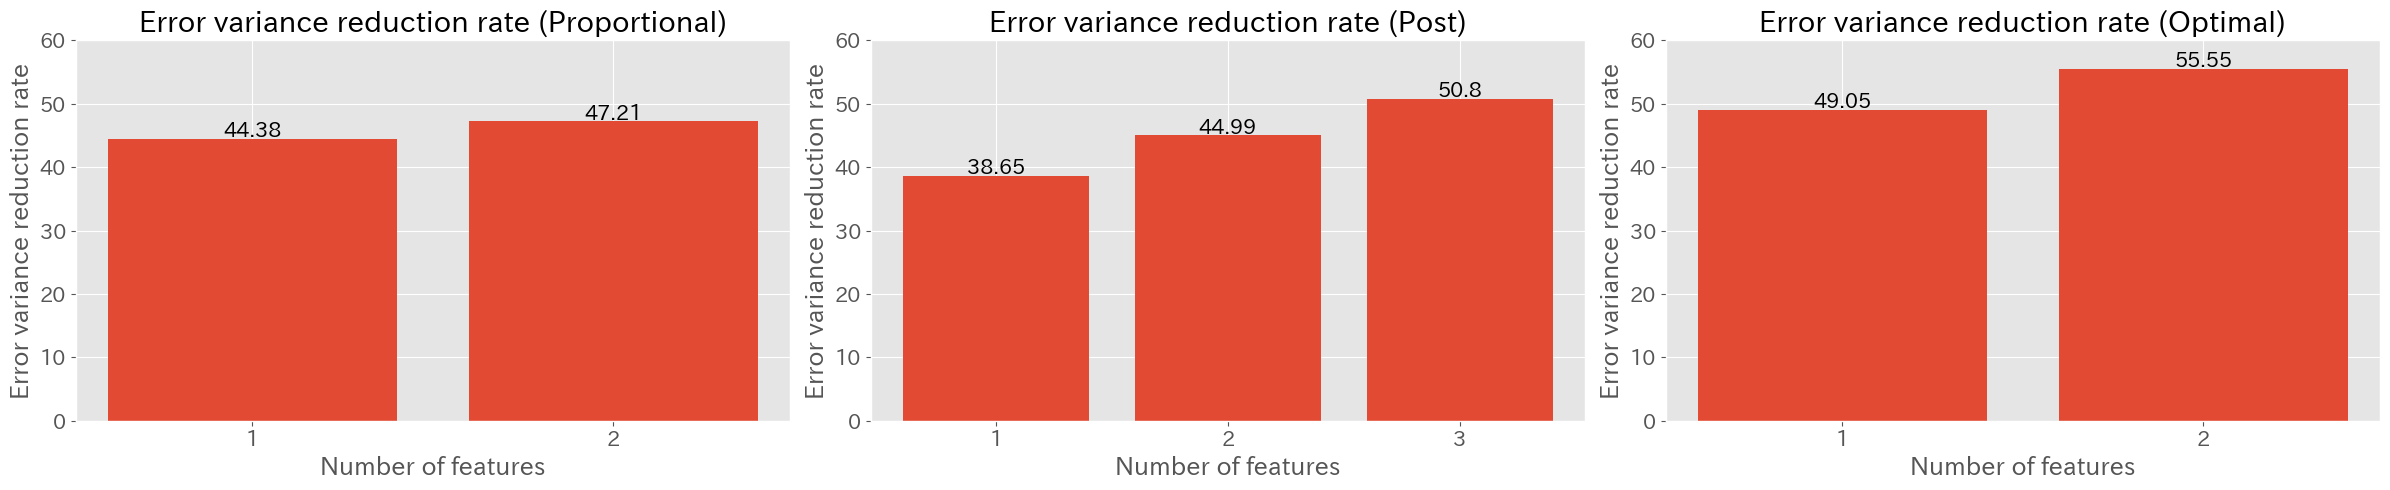

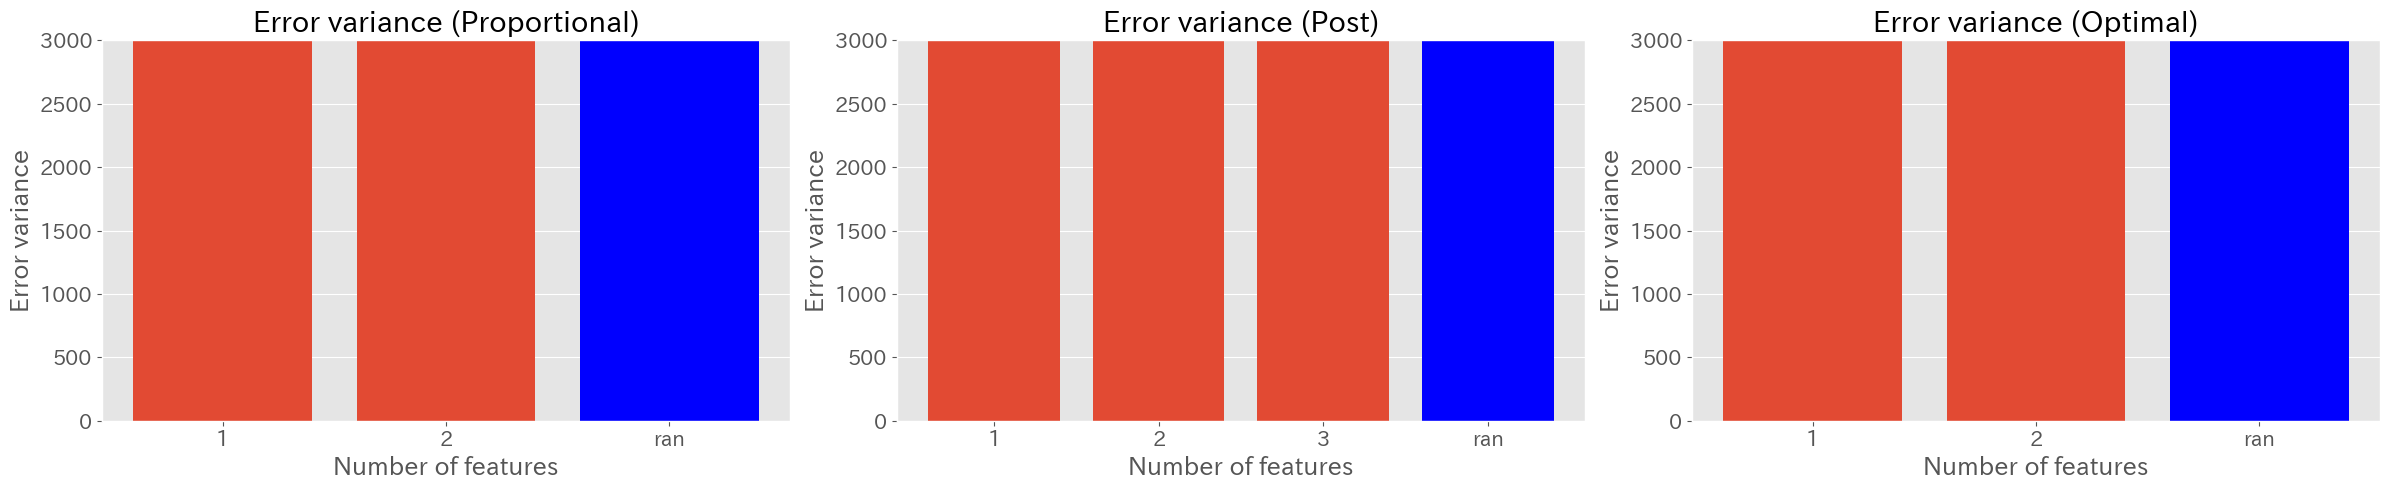

In [8]:
# グラフ作成
fig, axs = plt.subplots(
    1, len(ALLOCATION_METHODS), figsize=(8 * len(ALLOCATION_METHODS), 5)
)  # サブプロットを作成


plot_idx = 0
for allocation, dict in features_score_dict_dict.items():
    if len(features_score_dict_dict) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    bars = ax.bar(dict.keys(), dict.values())
    for key, value in dict.items():
        rounded_value = round(value, 2)
        ax.text(key, value + 0.3, str(rounded_value), ha="center", fontsize=15)
    ax.set_title(f"Error variance reduction rate ({allocation})", fontsize=21)
    ax.set_xlabel("Number of features", fontsize=18)
    ax.set_ylabel("Error variance reduction rate", fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_ylim([0, 60])  # Y軸の範囲を0から20に設定
    plot_idx += 1

plt.tight_layout()
plt.show()


# グラフ作成
fig, axs = plt.subplots(
    1, len(ALLOCATION_METHODS), figsize=(8 * len(ALLOCATION_METHODS), 5)
)  # サブプロットを作成

plot_idx = 0
for allocation, dict in features_error_variance_dict_dict.items():
    if len(features_score_dict_dict) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    bars = ax.bar(dict.keys(), dict.values())
    for key, value in dict.items():
        rounded_value = round(value, 2)
        # ax.text(key, value + 10, str(rounded_value), ha="center", fontsize=15)
    random_bar = ax.bar("ran", random_std, color="blue")
    # ax.text("random", random_std + 0.3, str(round(random_std, 2)), ha="center")
    ax.set_title(f"Error variance ({allocation})", fontsize=21)
    ax.set_xlabel("Number of features", fontsize=18)
    ax.set_ylabel("Error variance", fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_ylim([0, 3000])  # Y軸の範囲を0から20に設定
    plot_idx += 1

plt.tight_layout()
plt.show()

##### 実験回数がN_EXPERIMENT のとき

In [9]:
all_reduction_rate_dict = {}
for allocation_method in ALLOCATION_METHODS:
    all_reduction_rate_dict[allocation_method] = []
all_error_variance_dict = {}
for allocation_method in ALLOCATION_METHODS:
    all_error_variance_dict[allocation_method] = []
random_std_list = []

for random_state in range(N_EXPERIMENT):
    ins = Allocation_in_Wrapper(
        maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
        n_clusters=N_CLUSTERS,
        clustering_method=CLUSTERING_METHOD,
        allocation_methods=ALLOCATION_METHODS,
        sample_size=SAMPLE_SIZE,
        n_trials=N_TRIALS,
        m_value=m_VALUE,
        random_state=random_state,
        selecting_features=SELECTING_FEATURES,
        k_min=K_MIN,
        k_max=K_MAX,
    )

    ins.fss(X_scaled, y)
    final_score_dict = ins.get_final_score_dict()
    final_error_variance_dict = ins.get_final_error_variance_dict()
    random_std = ins.get_random_allocation_std()
    random_std_list.append(random_std)
    for allocation_method in ALLOCATION_METHODS:
        all_reduction_rate_dict[allocation_method].append(
            final_score_dict[allocation_method]
        )
        all_error_variance_dict[allocation_method].append(
            final_error_variance_dict[allocation_method]
        )

mean_reduction_rate_dict = {}
for allocation_method in ALLOCATION_METHODS:
    mean_reduction_rate_dict[allocation_method] = sum(
        all_reduction_rate_dict[allocation_method]
    ) / len(all_reduction_rate_dict[allocation_method])
mean_error_variance_dict = {}
for allocation_method in ALLOCATION_METHODS:
    mean_error_variance_dict[allocation_method] = sum(
        all_error_variance_dict[allocation_method]
    ) / len(all_error_variance_dict[allocation_method])
mean_random_std = sum(random_std_list) / len(random_std_list)


[ Proportional ]
num_of_features: 1 current_features: [13] , score: 34.21481668633872 best_n_clusters: 2 best_N_cluster_size: [46844 52238]
[ Post ]
num_of_features: 1 current_features: [4] , score: 21.426821004609952 best_n_clusters: 2 best_N_cluster_size: [84907 14175]
num_of_features: 2 current_features: [4, 8] , score: 26.48557699957689 best_n_clusters: 2 best_N_cluster_size: [75715 23367]
[ Optimal ]
num_of_features: 1 current_features: [0] , score: 38.15191991624397 best_n_clusters: 2 best_N_cluster_size: [88721 10361]
num_of_features: 2 current_features: [0, 15] , score: 39.38266997388803 best_n_clusters: 2 best_N_cluster_size: [18293 80789]
[ Proportional ]
num_of_features: 1 current_features: [6] , score: 21.58194739506134 best_n_clusters: 2 best_N_cluster_size: [21703 77379]
[ Post ]
num_of_features: 1 current_features: [4] , score: 19.391600870697467 best_n_clusters: 2 best_N_cluster_size: [84907 14175]
num_of_features: 2 current_features: [4, 5] , score: 23.273534169781772 

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_25412\2255830543.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)


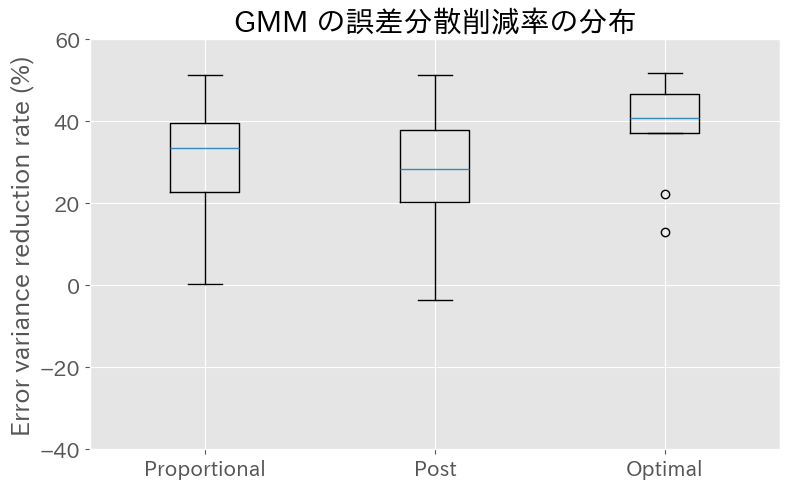

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_25412\2255830543.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)


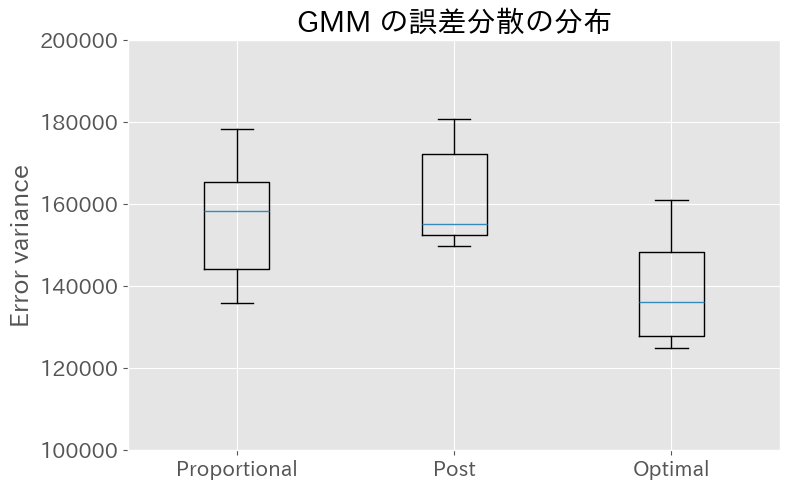

In [10]:
# 誤差分散削減率の箱ひげ図
fig, axs = plt.subplots(1, 1, figsize=(8, 5))  # サブプロットを作成

ax = axs
allo_data = list(all_reduction_rate_dict.values())  # allo1, allo2, allo3 のデータリスト
allo_labels = list(all_reduction_rate_dict.keys())  # alloのラベルリスト
ax.boxplot(allo_data, labels=allo_labels)
# グラフタイトルを設定
ax.set_title(f"{CLUSTERING_METHOD_NAME} の誤差分散削減率の分布", fontsize=21)
ax.set_ylabel("Error variance reduction rate (%)", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_ylim(-40, 60)

# グラフを表示
plt.tight_layout()  # レイアウトを調整
plt.show()


# 誤差分散の箱ひげ図
fig, axs = plt.subplots(1, 1, figsize=(8, 5))  # サブプロットを作成

ax = axs
allo_data = list(all_error_variance_dict.values())  # allo1, allo2, allo3 のデータリスト
allo_labels = list(all_error_variance_dict.keys())  # alloのラベルリスト
ax.boxplot(allo_data, labels=allo_labels)
# グラフタイトルを設定
ax.set_title(f"{CLUSTERING_METHOD_NAME} の誤差分散の分布", fontsize=21)
ax.set_ylabel("Error variance", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_ylim(100000, 200000)

# グラフを表示
plt.tight_layout()  # レイアウトを調整
plt.show()


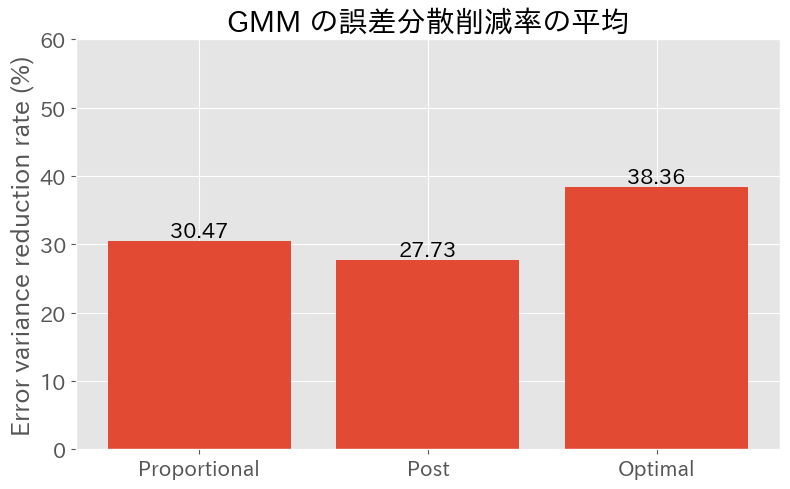

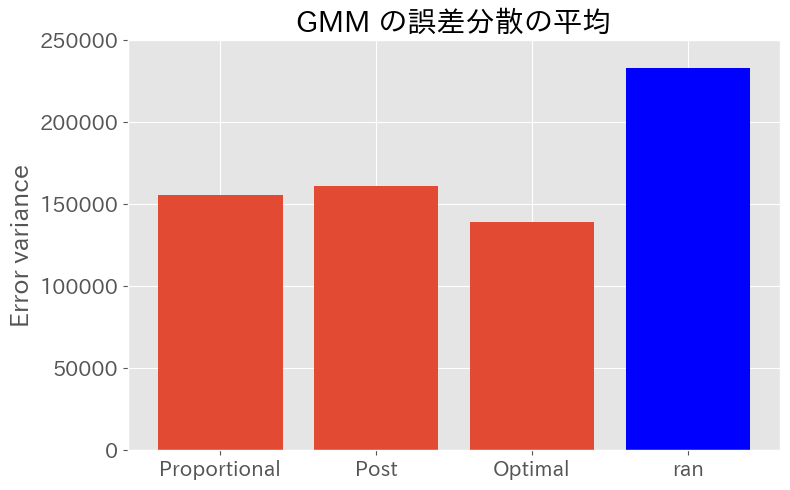

In [11]:
# グラフ作成
fig, axs = plt.subplots(
    1,
    1,
    figsize=(8, 5),
)  # サブプロットを作成

ax = axs
allo_data = list(
    mean_reduction_rate_dict.values()
)  # allo1, allo2, allo3 のデータリスト
allo_labels = list(mean_reduction_rate_dict.keys())  # alloのラベルリスト
bars = ax.bar(allo_labels, allo_data)
# 各バーの上に値を表示
for bar in bars:
    yval = bar.get_height()  # 各バーの高さ（値）
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
        fontsize=15,
    )  # 値をバーの上に表示
    # plt.ylabel("誤差分散削減率 (%)")
ax.set_ylabel("Error variance reduction rate (%)", fontsize=18)
ax.set_ylim(0, 60)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_title(
    f"{CLUSTERING_METHOD_NAME} の誤差分散削減率の平均", fontsize=21
)  # (number of clusters: {clusters})")

plt.tight_layout()
plt.show()


# グラフ作成
fig, axs = plt.subplots(
    1,
    1,
    figsize=(8, 5),
)  # サブプロットを作成

ax = axs
allo_data = list(
    mean_error_variance_dict.values()
)  # allo1, allo2, allo3 のデータリスト
allo_labels = list(mean_error_variance_dict.keys())  # alloのラベルリスト
bars = ax.bar(allo_labels, allo_data)
random_bar = ax.bar("ran", mean_random_std, color="blue")
ax.set_ylabel("Error variance", fontsize=18)
ax.set_ylim(0, 250000)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_title(f"{CLUSTERING_METHOD_NAME} の誤差分散の平均", fontsize=21)

plt.tight_layout()
plt.show()
